In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core_update')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core_update import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.1e-3,0.1e-3,0.1e-3),
            matrix_dims = (256,256,256),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=11.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

pos = 0.7

test_phantom.add_tissue_sphere((pos,-pos,0), 8, blood)
test_phantom.add_tissue_sphere((pos,0,0), 16, blood)
test_phantom.add_tissue_sphere((pos,pos,0), 32, blood)

test_phantom.add_tissue_sphere((-pos,-pos,0), 16, fat)
test_phantom.add_tissue_sphere((-pos,0,0), 32, fat)
test_phantom.add_tissue_sphere((-pos,pos,0), 8, fat)

test_phantom.add_tissue_sphere((0,-pos,0), 32, myocardium)
test_phantom.add_tissue_sphere((0,0,0), 8, myocardium)
test_phantom.add_tissue_sphere((0,pos,0), 16, myocardium)

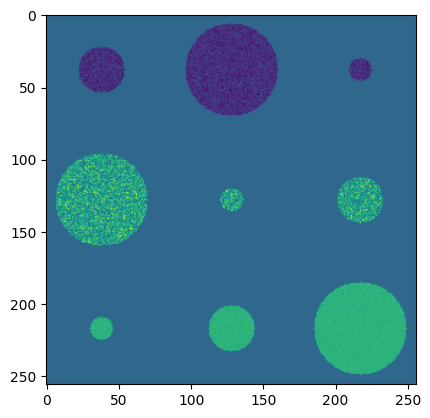

In [3]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [4]:
simprops = simulation.SimProperties(
                # grid_size   = (13e-3,4e-3,4e-3),
                grid_size   = (15e-3,5e-3,5e-3),
                voxel_size  = (0.02e-3,0.02e-3,0.02e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [5]:
simprops.matrix_size

array([1024,  256,  256])

In [8]:
transducers = [transducer.Focused(elements = 32, 
                       elevation = 1e-4 * 32, 
                       sensor_sampling_scheme = 'not_centroid', 
                       sweep = np.pi/4, 
                       ray_num = 32, 
                       imaging_ndims = 2,
                       focus_azimuth = 50e-3,
                       focus_elevation = 50e-3,
                       ) for i in range(8)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

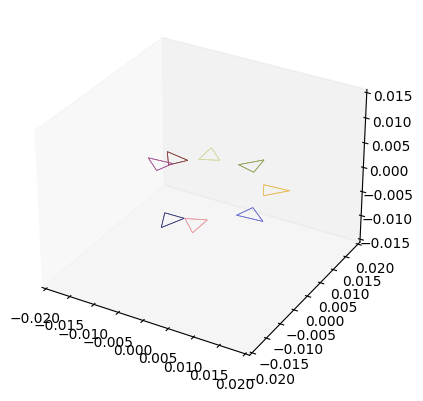

In [10]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 15e-3, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
test_transducer_set.plot_transducer_fovs(scale=0.02)

In [11]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='single_transducer')

In [57]:
simprops = simulation.SimProperties(
                grid_size   = (29e-3,2e-3,2e-3),
                voxel_size  = (0.02e-3,0.02e-3,0.02e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [58]:
simprops.matrix_size

array([2048,  128,  128])

In [59]:
1458/3/3/3/3/3/3

2.0

In [60]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/test_updated_experiment_1',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 2,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 )

test_experiment.save()

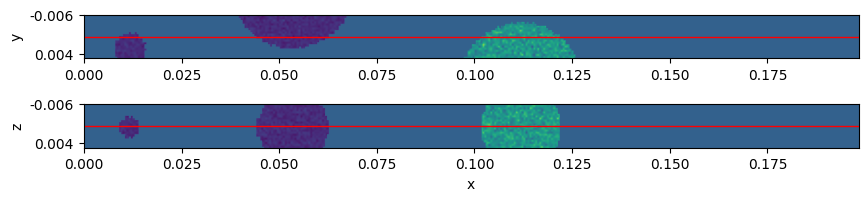

In [61]:
test_experiment.plot_ray_path(0)

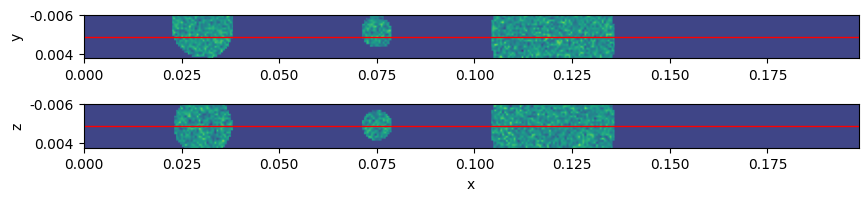

In [62]:
test_experiment.plot_ray_path(16)

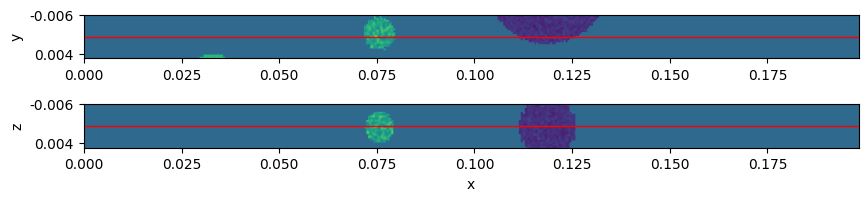

In [63]:
test_experiment.plot_ray_path(48)

In [64]:
test_experiment = experiment.Experiment.load('../experiment_files/test_updated_experiment_1')
test_experiment.run(dry=True)

Number of simulation results (37) does not match the expected number of simulation results (256), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]


In [65]:
test_experiment.run()

running with 3 workers

(2, 1984, 112, 112)
preparation for sim   35 completed in           10.49 seconds
(2, 1984, 112, 112)
preparation for sim   92 completed in           14.68 seconds
(2, 1984, 112, 112)
preparation for sim   36 completed in           11.49 seconds
(2, 1984, 112, 112)
preparation for sim   93 completed in           15.66 seconds
(2, 1984, 112, 112)
preparation for sim   37 completed in           11.71 seconds
(2, 1984, 112, 112)
preparation for sim   94 completed in           14.44 seconds


┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                           2048 x 128 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   6001 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                           2048 x 128 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   6001 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                           2048 x 128 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   6001 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                           2048 x 128 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   6001 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                           2048 x 128 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   6001 │
├───────────────────────────────────────────────────────────────┤
│         

In [ ]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [ ]:
test_reconstruction.plot_scatter()

In [ ]:
test_experiment.add_results()

In [ ]:
plt.plot(test_experiment.results[30][1].T)